In [1]:
import numpy as np
import pandas as pd
import os
import random
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
csv_path = os.path.join('/content/drive/MyDrive', 'train.csv')
train = pd.read_csv(csv_path)
bbox_df = pd.DataFrame(train['bbox'].apply(lambda x: x[1:-1].split(',')).tolist(), columns=['x1', 'y1', 'w', 'h'])

bbox_df['x1'] = pd.to_numeric(bbox_df['x1'])
bbox_df['y1'] = pd.to_numeric(bbox_df['y1'])
bbox_df['w'] = pd.to_numeric(bbox_df['w'])
bbox_df['h'] = pd.to_numeric(bbox_df['h'])

bbox_df['x2'] = bbox_df['x1'] + bbox_df['w']
bbox_df['y2'] = bbox_df['y1'] + bbox_df['h']


bbox_df.drop(['w', 'h'], axis=1, inplace=True)

ds = pd.concat([train, bbox_df], axis=1)

ds.drop(['bbox', 'width', 'height', 'source'], axis=1, inplace=True)

print(ds.head())


    image_id     x1     y1     x2     y2
0  b6ab77fd7  834.0  222.0  890.0  258.0
1  b6ab77fd7  226.0  548.0  356.0  606.0
2  b6ab77fd7  377.0  504.0  451.0  664.0
3  b6ab77fd7  834.0   95.0  943.0  202.0
4  b6ab77fd7   26.0  144.0  150.0  261.0


In [4]:
unique_images = ds.image_id.unique()


In [5]:
unique_images

array(['b6ab77fd7', 'b53afdf5c', '7b72ea0fb', ..., 'a5c8d5f5c',
       'e6b5e296d', '5e0747034'], dtype=object)

In [6]:
class CustDat(torch.utils.data.Dataset):
    def __init__(self, df, unique_imgs, indices):
        self.df = df
        self.unique_imgs = unique_imgs
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image_name = self.unique_imgs[self.indices[idx]]
        boxes = self.df[self.df.image_id == image_name].values[:, 1:].astype("float")
        img = Image.open("/content/drive/MyDrive/train/" + image_name + ".jpg").convert('RGB')
        labels = torch.ones((boxes.shape[0]), dtype=torch.int64)
        target = {}
        target["boxes"] = torch.tensor(boxes)
        target["labels"] = labels
        return T.ToTensor()(img), target

In [7]:
train_inds, val_inds = train_test_split(range(unique_images.shape[0]), test_size=0.1)

def custom_collate(data):
    return data


In [8]:
train_dl = torch.utils.data.DataLoader(
    CustDat(ds, unique_images, train_inds),
    batch_size=5,
    shuffle=True,
    collate_fn=custom_collate,
    pin_memory=True if torch.cuda.is_available() else False
)

val_dl = torch.utils.data.DataLoader(
    CustDat(ds, unique_images, val_inds),
    batch_size=8,
    shuffle=True,
    collate_fn=custom_collate,
    pin_memory=True if torch.cuda.is_available() else False
)


In [9]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:03<00:00, 52.0MB/s]


In [10]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
num_epochs = 5


In [11]:
model.to(device)
for epochs in range(num_epochs):
    epoch_loss = 0
    for data in train_dl:
        imgs = []
        targets = []
        for d in data:
            imgs.append(d[0].to(device))
            targ = {}
            targ["boxes"] = d[1]["boxes"].to(device)
            targ["labels"] = d[1]["labels"].to(device)
            targets.append(targ)
        loss_dict = model(imgs, targets)
        loss = sum(v for v in loss_dict.values())
        epoch_loss += loss.cpu().detach().numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(loss)


tensor(4.5702, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3.3117, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1.6294, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1.8090, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1.9373, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1.8887, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1.8703, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1.7558, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1.6726, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1.6477, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1.5693, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1.7058, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1.5647, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)

In [13]:
model.eval()
data = iter(val_dl).__next__()

img = data[0][0]
boxes = data[0][1]["boxes"]
labels = data[0][1]["labels"]

output = model([img.to(device)])
output


[{'boxes': tensor([[4.0449e+02, 1.9804e+02, 4.8990e+02, 3.0191e+02],
          [9.4061e+02, 5.9660e+01, 1.0014e+03, 1.3685e+02],
          [5.9240e+02, 6.6794e+02, 6.6281e+02, 7.4122e+02],
          [2.0254e+00, 7.9352e+02, 1.0157e+02, 8.9698e+02],
          [3.6075e+02, 2.8712e+02, 4.2945e+02, 3.7147e+02],
          [7.7705e+02, 1.0480e+00, 8.4622e+02, 6.0368e+01],
          [4.6138e+01, 5.0572e+02, 1.2501e+02, 5.9304e+02],
          [4.2319e+02, 3.1855e+02, 4.9171e+02, 3.8675e+02],
          [7.4510e+02, 8.8992e+02, 8.2320e+02, 9.6435e+02],
          [1.0330e+02, 2.9515e+02, 1.6788e+02, 3.5718e+02],
          [9.7911e+02, 8.2072e+02, 1.0240e+03, 9.0471e+02],
          [4.1115e+02, 4.2102e+02, 5.0655e+02, 5.1460e+02],
          [8.7180e+02, 4.9343e+02, 9.4365e+02, 5.8120e+02],
          [8.5788e+02, 2.4079e+02, 9.1942e+02, 3.3787e+02],
          [8.6892e+02, 5.6375e+02, 9.3088e+02, 6.2756e+02],
          [1.3666e+02, 8.4188e+02, 2.0389e+02, 9.3961e+02],
          [2.2847e+02, 9.0640e+

In [14]:
out_bbox = output[0]["boxes"]
out_scores = output[0]["scores"]
keep = torchvision.ops.nms(out_bbox, out_scores, 0.45)
out_bbox.shape, keep.shape

(torch.Size([85, 4]), torch.Size([80]))

In [15]:
out_bbox.shape, keep.shape

im = (img.permute(1, 2, 0).cpu().detach().numpy() * 255).astype('uint8')


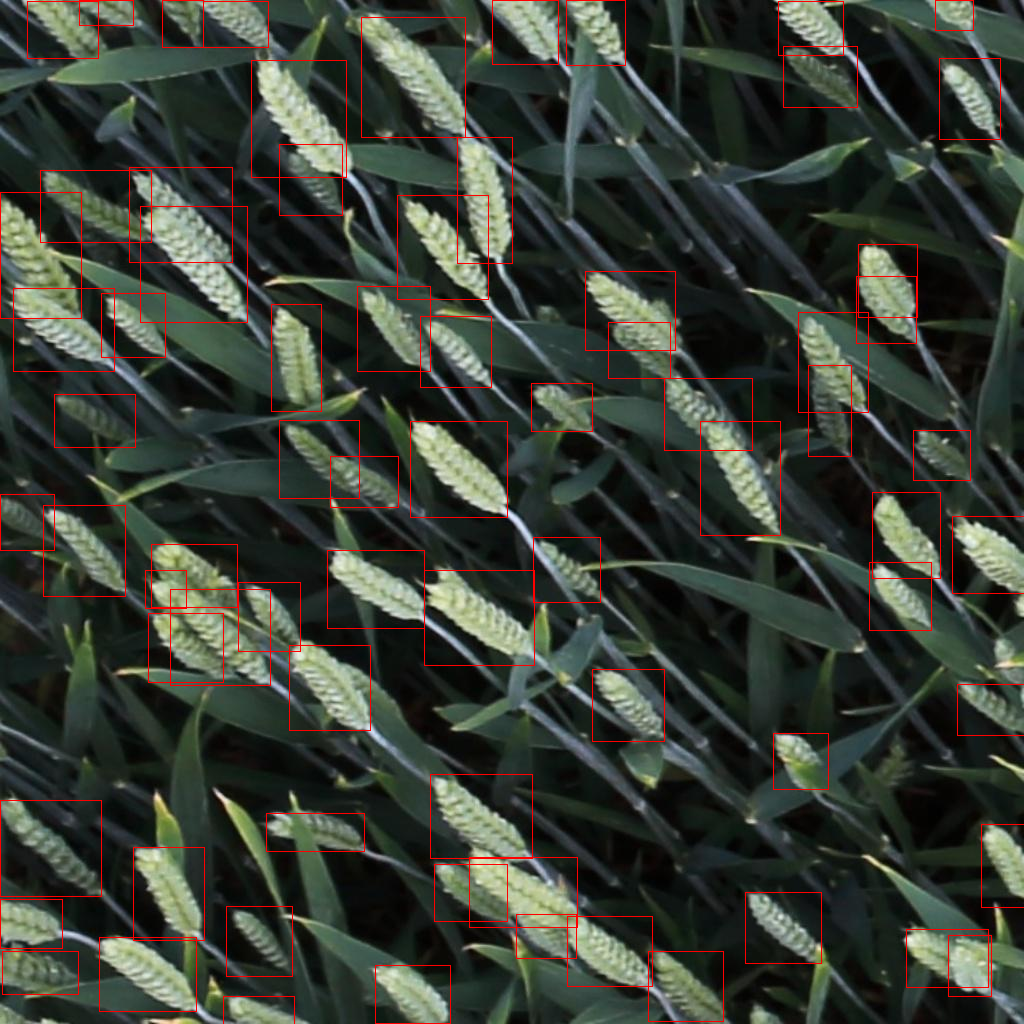

In [16]:
vsample = Image.fromarray(im)

draw = ImageDraw.Draw(vsample)
for box in boxes:
    draw.rectangle(list(box), fill=None, outline="red")
vsample

### Model diagram

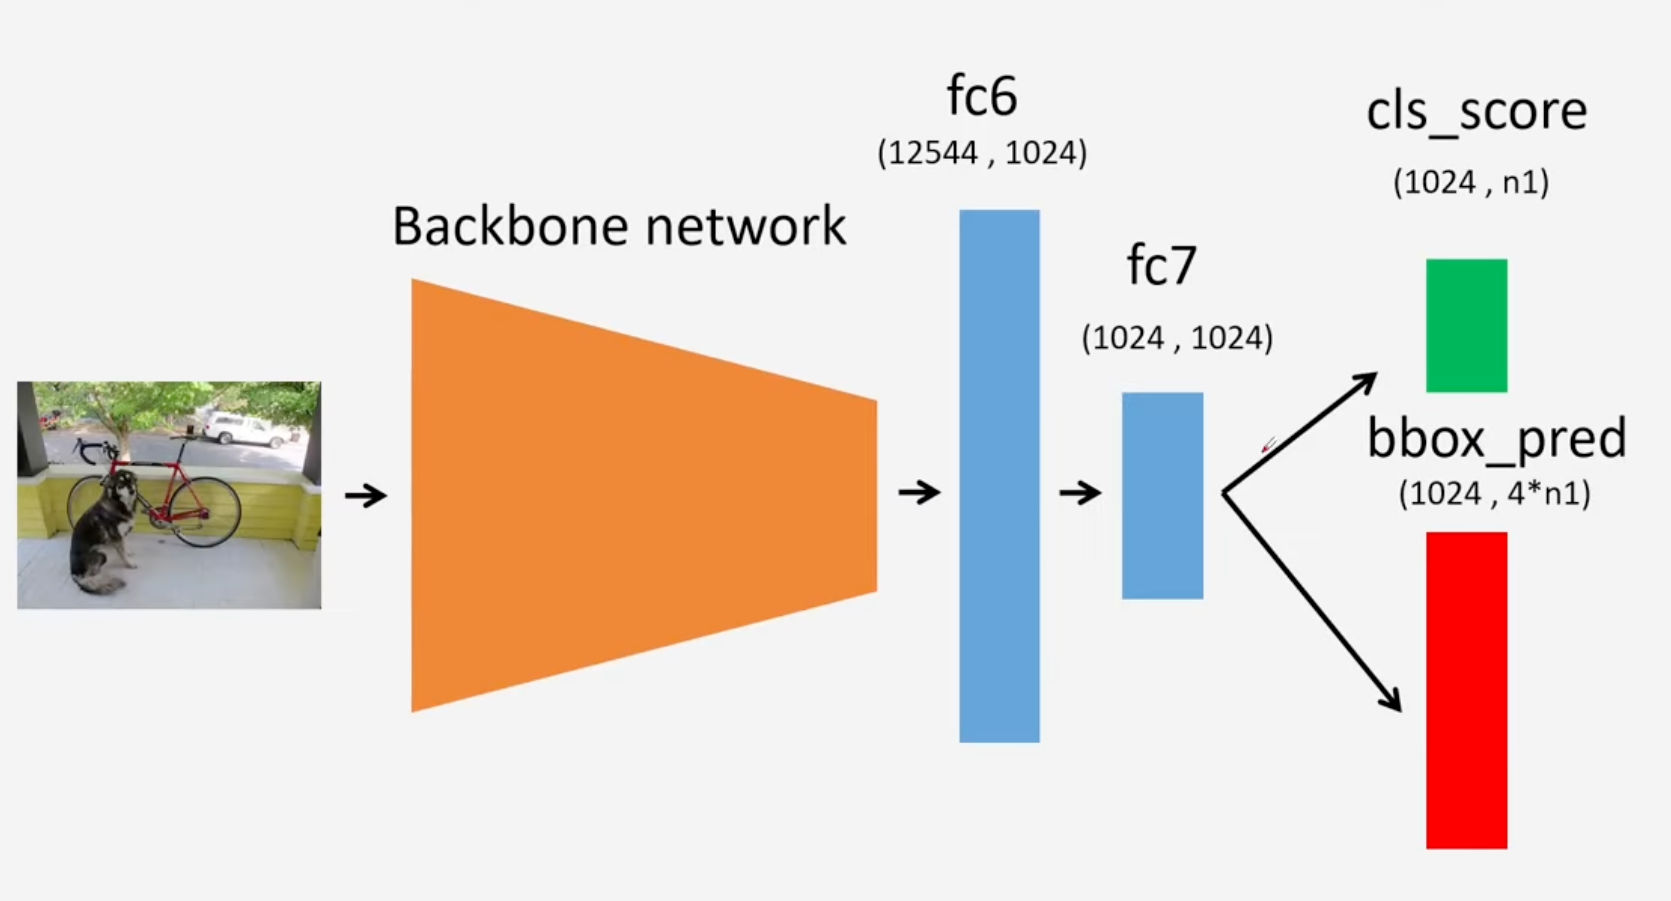